In [1]:
import pandas as pd
import segysak
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import glob
from scratch.util import plot_hist_pars, CreateSeismicModel, nn_interp_coords

In [2]:
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis

In [3]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [4]:
sc_path = '2D_Scenarios'
scenarios = glob.glob(sc_path+r'/sc*')
scenarios

['2D_Scenarios/sc_2', '2D_Scenarios/sc_1']

Эту модель будут варьировать на предмет наличия талых зон, поэтому будет несколько сценариев, для каждого сценария своя моделька

Ниже датафрейм с координатами приборов. Это и приемники, и источники одновременно, т.е. всего будет 319 сейсмограмм по 319 трасс

In [5]:
df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
df_ins['X'] = np.linspace(0,7950, 319)
df_ins

,X,Surf_idx,Z
0,0.0,26,52.0
1,25.0,26,52.0
2,50.0,27,54.0
3,75.0,27,54.0
4,100.0,27,54.0
...,...,...,...
314,7850.0,34,68.0
315,7875.0,34,68.0
316,7900.0,34,68.0
317,7925.0,34,68.0


In [6]:
constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

В изначальных моделях есть корявые ячейки у самой поверхности, где Vp очень низкие, контраст с соседними ячейками достигает 2000+. Когда волновой процесс доходит до этих ячеек, очень часто вылезает вычислительная неустойчивость. Не хочется ради них задирать порядок аппроксимации и улучшать дискретизацию<br>
Код ниже позволяет убрать их

In [7]:
for i, scenario in enumerate(scenarios[1:]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185}
                                        )
    el_pars = {file.split('/')[-1].split(' ')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    for k, v in el_pars.items():
        el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки

    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    # Верхний слой со свойствами воды
    rho_data[rho_data==0] = 1.
    vp_data[vp_data==0] = 1.5
    vs_data[vs_data==0] = 0.0

    # сетка
    
    
    # инт данные
    

    # модель
    
    
    # оператор

    
    # выгрузка в sgy

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

In [8]:
dim_vectors = ((el_pars['Rho'].cdp.data-1)*25, (el_pars['Rho'].samples.data))
spacing = (1, 1) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
origin = (0, 0)
nbl = 20
so = 8

In [9]:
rho_data_int = nn_interp_coords(rho_data, origin, (7950, 1000), spacing, dim_vectors)
vp_data_int = nn_interp_coords(vp_data, origin, (7950, 1000), spacing, dim_vectors)
vs_data_int = nn_interp_coords(vs_data, origin, (7950, 1000), spacing, dim_vectors)

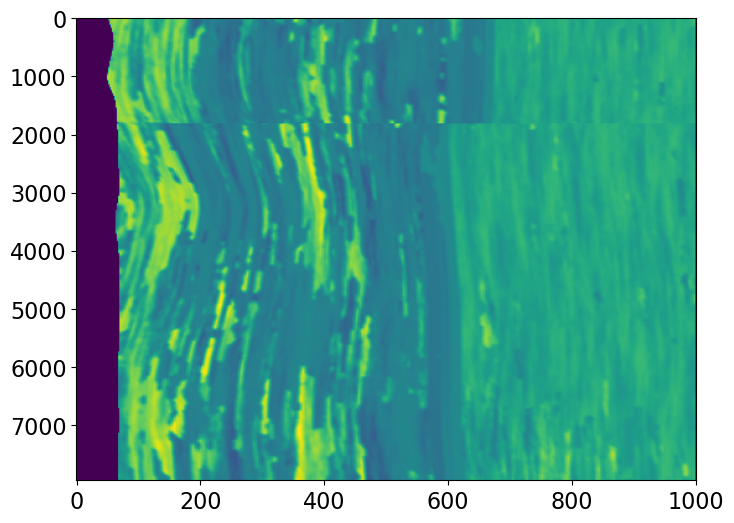

In [10]:
plt.imshow(vp_data_int, aspect='auto')

In [11]:
model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='damp',
                          )

Operator `initdamp` ran in 0.06 s


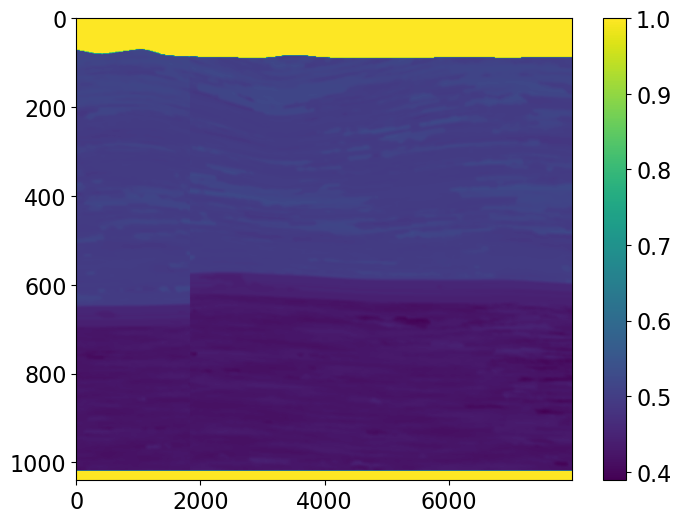

In [12]:
plt.imshow(model.b.data.T, aspect='auto')
plt.colorbar()

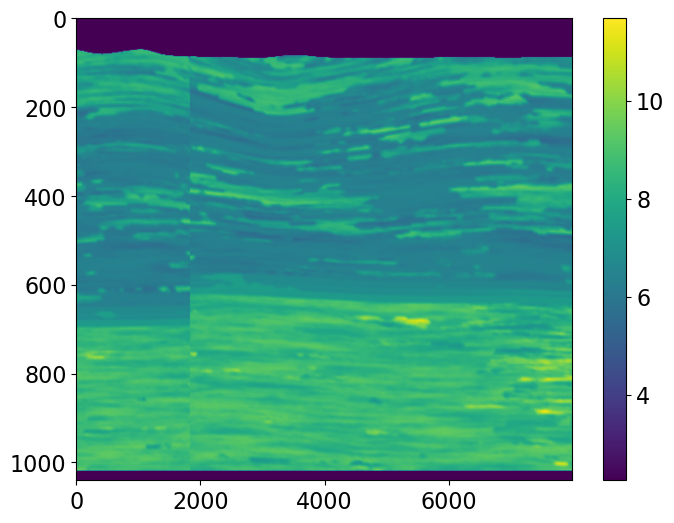

In [13]:
# plt.imshow(model.lam.data.T,aspect='auto')
# plt.colorbar()

In [14]:
model.critical_dt

0.1673

In [15]:
t0, tn = 0., 2000.
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid = model.grid, f0=0.025, time_range=time_range)
# src.coordinates.data[:] = [df_ins['X'][159], df_ins['Z'][159]]
src.coordinates.data[:] = [df_ins['X'][159], 0]

In [16]:
#create velocity and pressure fields
s = model.grid.time_dim.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=2)

In [17]:
# The source injection term
# src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=s*src) # Источник направленной силы
# src_zz = src.inject(field=v.forward[1], expr=s*src) # А это, согласно литературе, все же не является классическим источником направленной силы


# The receiver
nrec = df_ins.shape[0]

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:,0] = df_ins['X']
rec.coordinates.data[:,1] = df_ins['Z']
# rec.coordinates.data[:,1] = 0.

rec_term = rec.interpolate(expr=v[1])
# rec_term = rec.interpolate(expr=tau[0,0] + tau[1,1])

In [18]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).transpose(inner=False))
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] +
              # src_xx + 
              src_zz + 
              rec_term, platform='nvidiaX')

In [19]:
vp_data_int.shape

(7951, 1001)

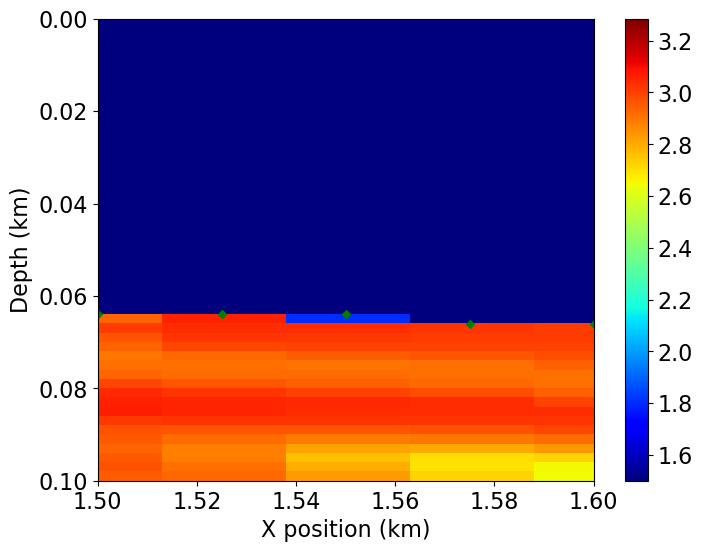

In [20]:
cmap = "jet"
scale = 1
vscale = 10
domain_size = 1.e-3 * np.array(model.domain_size)
extent = [model.origin[0], model.origin[0] + domain_size[0],
          model.origin[1] + domain_size[1], model.origin[1]]

slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
if getattr(model, 'vp', None) is not None:
    field = model.vp.data[slices]
else:
    field = (model.vp.data[slices])
plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                  vmin=np.min(field), vmax=np.max(field),
                  extent=extent, aspect='auto')

plt.xlabel('X position (km)')
plt.ylabel('Depth (km)')

plt.scatter(1e-3*rec.coordinates.data[:, 0], 1e-3*rec.coordinates.data[:, 1],
                    s=15, c='green', marker='D')
plt.colorbar(plot)

plt.xlim([1.5, 1.600]) # Пределы можно регулировать
plt.ylim([0.1, 0])
plt.show()

In [21]:
op(dt=dt)

Operator `Kernel` ran in 39.42 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=38.152578999999925, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.7989230000000052, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.33127700000006893, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [22]:
rec_max = rec.data.max(axis=0)
rec_max[rec_max == 0] = 1
rec_trace_norm = rec.data / rec_max

In [23]:
rec.data.shape

(11956, 319)

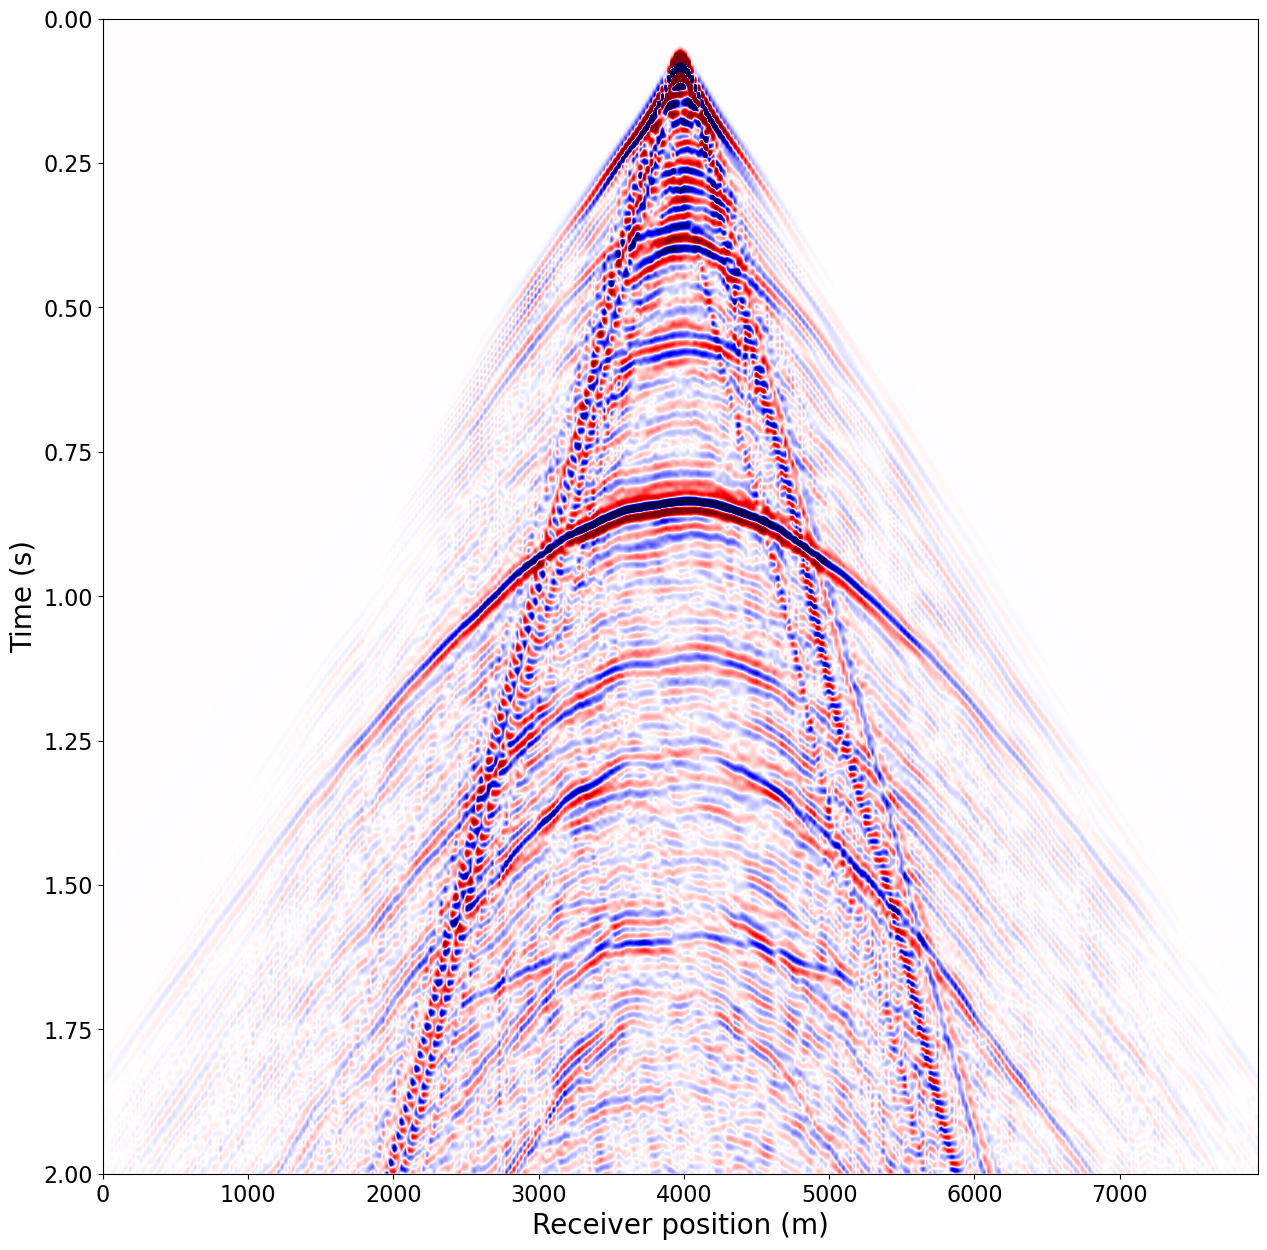

In [25]:
#NBVAL_SKIP
# Pressure (txx + tzz) data at sea surface
extent = [rec.coordinates.data[0, 0], rec.coordinates.data[-1, 0], 1e-3*tn, t0]
aspect = rec.coordinates.data[-1, 0]/(1e-3*tn)
vminmax = np.max(np.abs(rec.data))
gain = 2e1
sc = vminmax/gain
plt.figure(figsize=(15, 15))
plt.imshow(rec.data[::5,:], vmin=-sc, vmax=sc, cmap="seismic",
           interpolation='bilinear', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)
plt.show()